## Notebook for plotting generated dCS strain data

In [1]:
# imports
from matplotlib import rc
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import json
from Generate_dCS_Strain import *
from scipy.signal import argrelextrema
rc('text', usetex=True)
from scipy.optimize import fmin

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [2]:
def CutTimes(time, data, TLow, TUp): 
    """ Cut time and data to be between 
        TLow and TUp  """
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

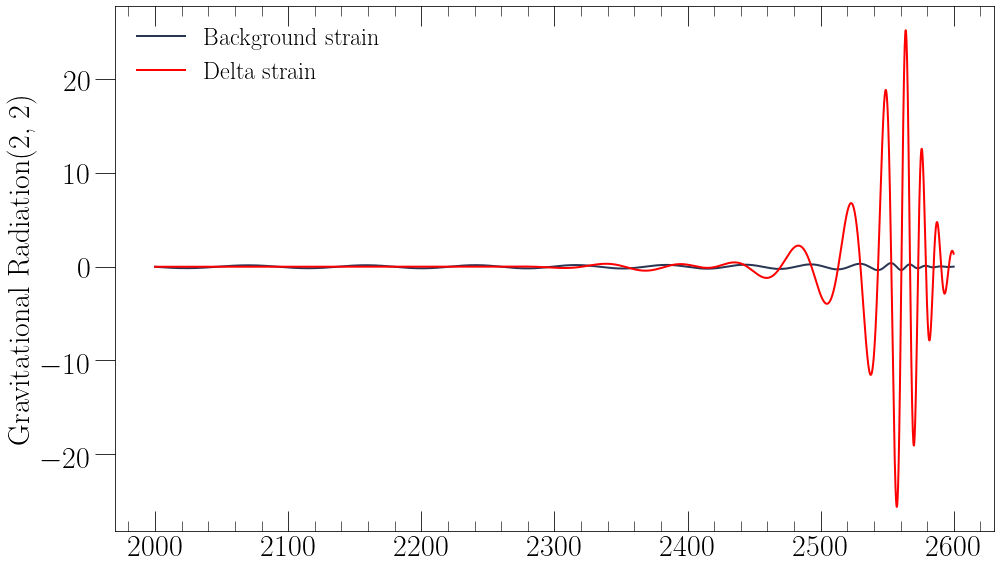

In [3]:
# Plot the strains
def PlotStrain():
    
    f, ax = plt.subplots(1, figsize=(14,8))
    mode = (2,2)
    order = 2
    p = "Waveforms"

    ## Grab delta psi4 and compute delta h
    time, strain = ReadExtrapolatedMode(p, "BackgroundStrain", mode, order)
    delta_time, delta_strain = ReadExtrapolatedMode(p, "DeltaStrain", mode, order)

    #mod_time, mod_strain = ReadExtrapolatedMode(p, "dCSModified", mode, order, ell=0.0)
    
    start = 2000
    stop = 2600
    time, strain = CutTimes(time, strain, start, stop)
    delta_time, delta_strain = CutTimes(delta_time, delta_strain, start, stop)
    #mod_time, mod_strain = CutTimes(mod_time, mod_strain, start, stop)
    
    ax.plot(time, np.real(strain), label='Background strain', color='#283653', lw=2.0)
    ax.plot(delta_time, np.real(delta_strain), label='Delta strain', color='red', lw=2.0)
    #ax.plot(mod_time, np.real(mod_strain), label='Modified strain', color='blue', ls='--', lw=2.0)

    
    #plt.axvline(0.0, color='black', lw=1.0)

    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1)
    ax.set_ylabel('Gravitational Radiation' + str(mode), fontsize=30)

    #ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.show()     

PlotStrain()

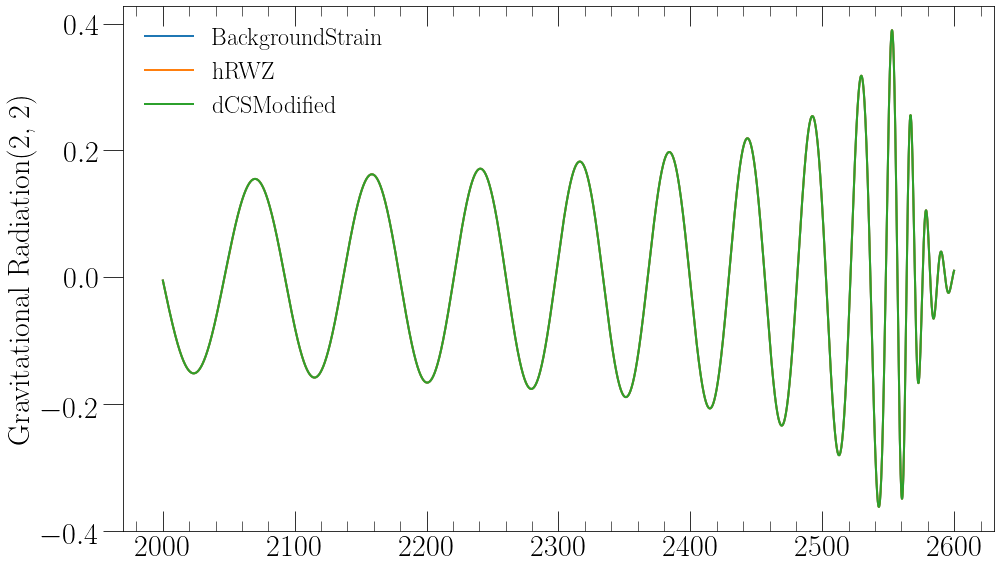

In [10]:
# Plot the strains
def PlotGRStrains():
    
    f, ax = plt.subplots(1, figsize=(14,8))
    mode = (2,2)
    order = 2
    start = 2000
    stop = 2600
    p = "Waveforms"

    def PlotWaveform(f):
        time, strain = ReadExtrapolatedMode(p, f, mode, order, ell=0.0)
        time, strain = CutTimes(time, strain, start, stop)

        ax.plot(time, np.real(strain), label=f, lw=2.0)
 
    PlotWaveform("BackgroundStrain")
    PlotWaveform("hRWZ")
    PlotWaveform("dCSModified")
    
    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1)
    ax.set_ylabel('Gravitational Radiation' + str(mode), fontsize=30)

    #ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.show()     

PlotGRStrains()

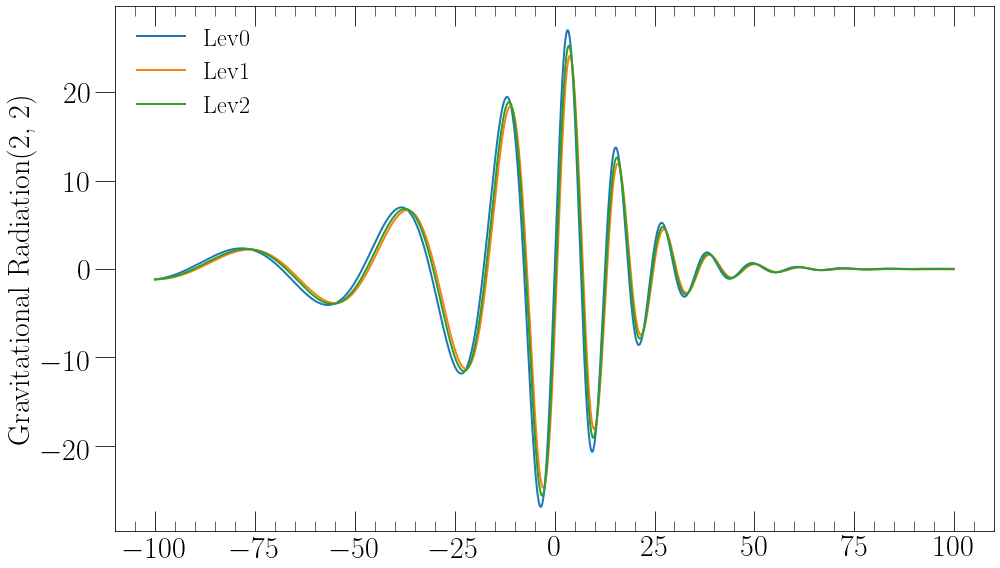

In [4]:
# Plot the strains
def PlotStrainResolutions():
    
    f, ax = plt.subplots(1, figsize=(14,8))
    mode = (2,2)
    order = 2
    start = -100
    stop = 100
    p = "Waveforms"

    data_type = "DeltaStrain"
    
    for Lev in ['Lev0', 'Lev1', 'Lev2']:
        time, strain = ReadExtrapolatedMode(p + '/' + Lev, data_type, mode, order)
        time = SubtractPeakTimeMode(time, strain)
        time, strain = CutTimes(time, strain, start, stop)
        ax.plot(time, np.real(strain), label=Lev, lw=2.0)

    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1)
    ax.set_ylabel('Gravitational Radiation' + str(mode), fontsize=30)

    #ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.show()     

PlotStrainResolutions()